In [1]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
pd.__version__

'2.2.3'

In [3]:
df = pd.read_parquet('../data/yellow_tripdata_2024-01.parquet')

In [4]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [5]:
# Converter as colunas de datetime
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calcular a duração em minutos
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Verificar a distribuição da duração
print(f"Estatísticas da duração das viagens (minutos):")
print(df['trip_duration'].describe())

Estatísticas da duração das viagens (minutos):
count    2.964624e+06
mean     1.561295e+01
std      3.485105e+01
min     -1.356667e+01
25%      7.150000e+00
50%      1.163333e+01
75%      1.868333e+01
max      9.455400e+03
Name: trip_duration, dtype: float64



Valores faltantes por coluna:
VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
trip_duration                 0
dtype: int64

Correlação com a duração da viagem:
trip_duration      1.000000
fare_amount        0.247386
total_amount       0.243685
passenger_count    0.021718
trip_distance      0.005398
Name: trip_duration, dtype: float64


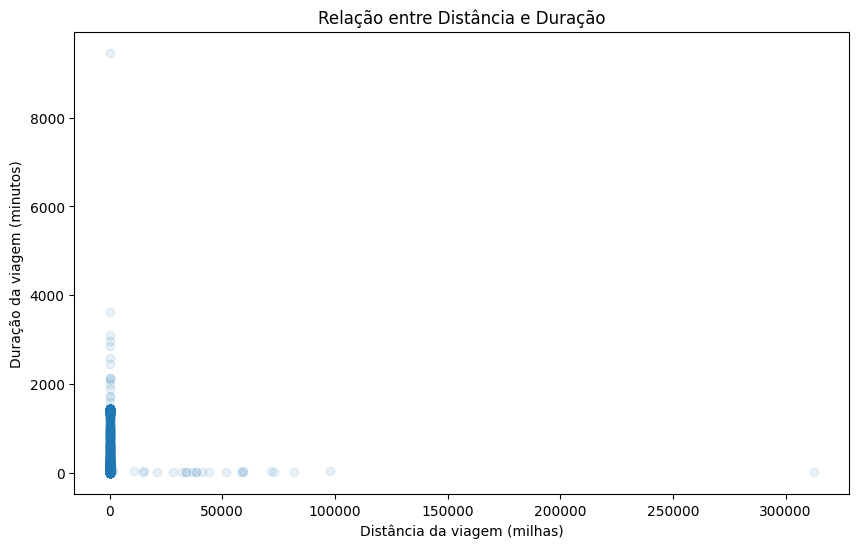

In [6]:
# Verificar valores faltantes
print("\nValores faltantes por coluna:")
print(df.isnull().sum())

# Analisar correlações com a duração
features = ['trip_distance', 'passenger_count', 'fare_amount', 'total_amount']
print("\nCorrelação com a duração da viagem:")
print(df[features + ['trip_duration']].corr()['trip_duration'].sort_values(ascending=False))

# Plotar relação entre distância e duração
plt.figure(figsize=(10, 6))
plt.scatter(df['trip_distance'], df['trip_duration'], alpha=0.1)
plt.xlabel('Distância da viagem (milhas)')
plt.ylabel('Duração da viagem (minutos)')
plt.title('Relação entre Distância e Duração')
plt.show()

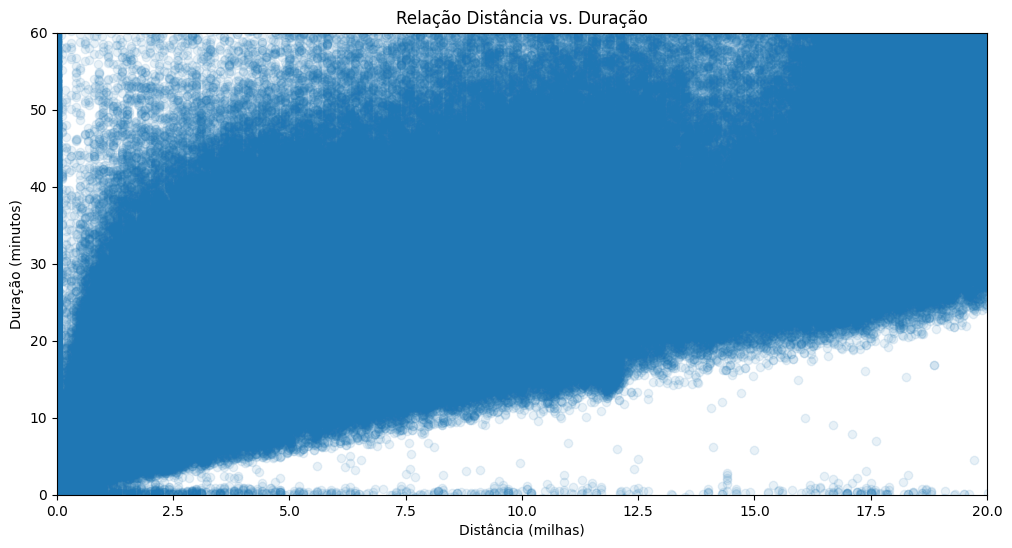

Número de viagens com valores extremos: 5337


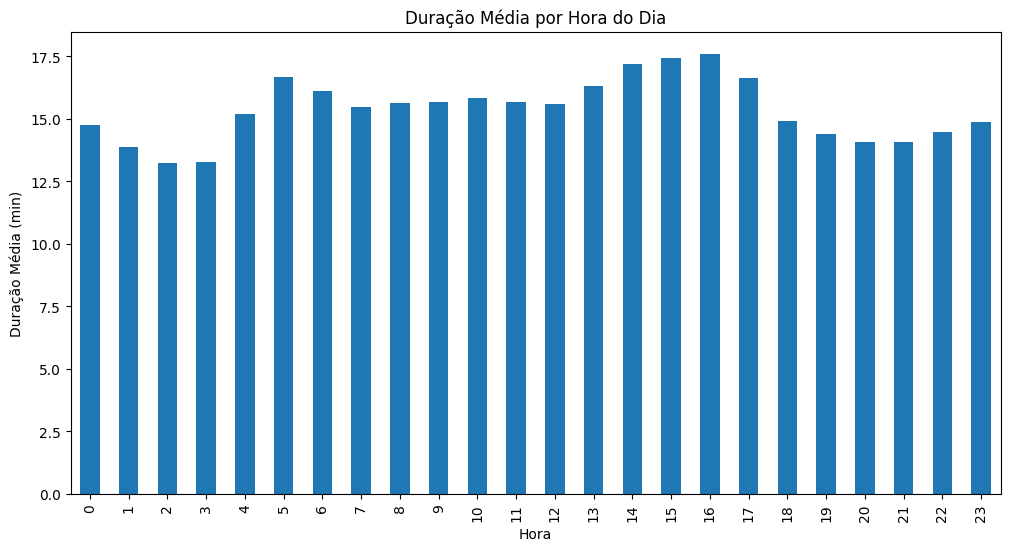

In [7]:
# Investigar anomalias na relação distância-duração
plt.figure(figsize=(12, 6))
plt.scatter(df['trip_distance'], df['trip_duration'], alpha=0.1)
plt.xlabel('Distância (milhas)')
plt.ylabel('Duração (minutos)')
plt.title('Relação Distância vs. Duração')
plt.xlim(0, 20)  # Limitar para melhor visualização
plt.ylim(0, 60)
plt.show()

# Verificar viagens com duração ou distância extremas
extremes = df[(df['trip_duration'] > 120) | (df['trip_distance'] > 30)]
print(f"Número de viagens com valores extremos: {len(extremes)}")
extremes.head()

# Explorar fatores temporais
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

# Duração média por hora do dia
hourly_duration = df.groupby('hour')['trip_duration'].mean()
plt.figure(figsize=(12, 6))
hourly_duration.plot(kind='bar')
plt.title('Duração Média por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Duração Média (min)')
plt.show()

In [12]:
# Estatísticas gerais do gráfico
print(df[['trip_distance', 'trip_duration']].describe())

# Para entender melhor a relação
print(df.groupby(pd.cut(df['trip_distance'], bins=10), observed=True)['trip_duration'].mean())

       trip_distance  trip_duration
count   2.964624e+06   2.964624e+06
mean    3.652169e+00   1.561295e+01
std     2.254626e+02   3.485105e+01
min     0.000000e+00  -1.356667e+01
25%     1.000000e+00   7.150000e+00
50%     1.680000e+00   1.163333e+01
75%     3.110000e+00   1.868333e+01
max     3.127223e+05   9.455400e+03
trip_distance
(-312.722, 31272.23]     15.612938
(31272.23, 62544.46]     15.083333
(62544.46, 93816.69]     27.000000
(93816.69, 125088.92]    27.000000
(281450.07, 312722.3]    13.000000
Name: trip_duration, dtype: float64


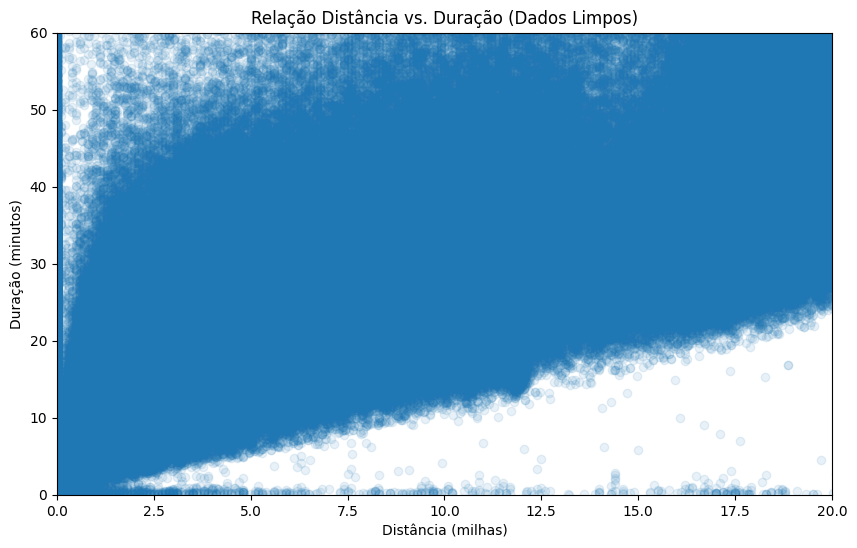

               trip_distance  trip_duration
trip_distance       1.000000       0.783228
trip_duration       0.783228       1.000000


In [13]:
# Remover valores impossíveis
df_clean = df.copy()

# Remover durações negativas
df_clean = df_clean[df_clean['trip_duration'] > 0]

# Remover viagens irrealistas
df_clean = df_clean[df_clean['trip_distance'] < 100]  
df_clean = df_clean[df_clean['trip_duration'] < 180]

# 3. Visualizar dados após limpeza
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['trip_distance'], df_clean['trip_duration'], alpha=0.1)
plt.xlabel('Distância (milhas)')
plt.ylabel('Duração (minutos)')
plt.title('Relação Distância vs. Duração (Dados Limpos)')
plt.xlim(0, 20)
plt.ylim(0, 60)
plt.show()

# 4. Verificar nova correlação
print(df_clean[['trip_distance', 'trip_duration']].corr())

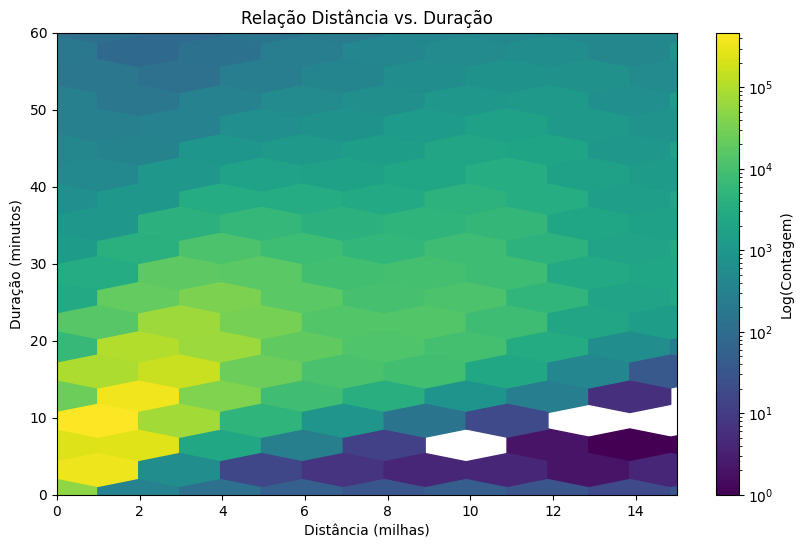

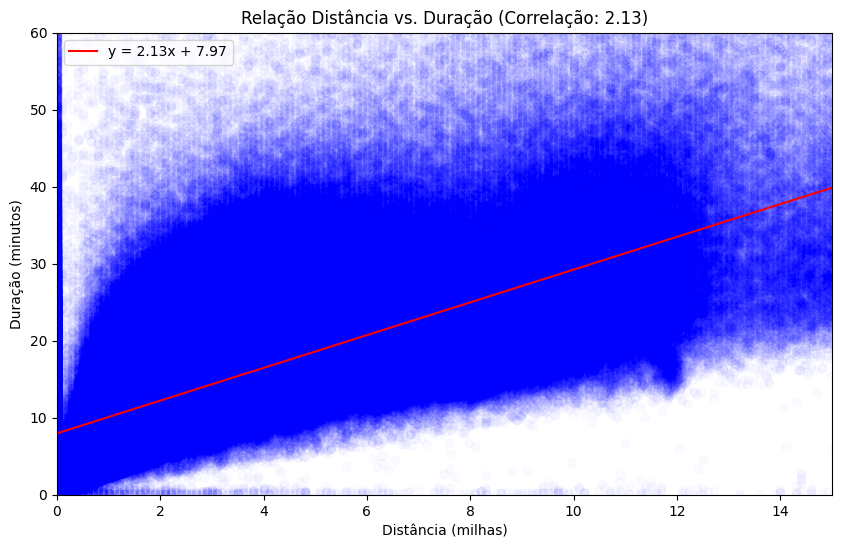

In [14]:
# Melhorar a visualização com hexbin (mapa de calor)
plt.figure(figsize=(10, 6))
plt.hexbin(df_clean['trip_distance'], df_clean['trip_duration'], 
           gridsize=50, cmap='viridis', bins='log')
plt.colorbar(label='Log(Contagem)')
plt.xlabel('Distância (milhas)')
plt.ylabel('Duração (minutos)')
plt.title('Relação Distância vs. Duração')
plt.xlim(0, 15) 
plt.ylim(0, 60) 
plt.show()

# Gráfico com linha de tendência
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['trip_distance'], df_clean['trip_duration'], alpha=0.02, color='blue')

# Linha de tendência
slope, intercept, r, p, std_err = stats.linregress(df_clean['trip_distance'], df_clean['trip_duration'])
x = np.array([0, df_clean['trip_distance'].max()])
y = intercept + slope * x
plt.plot(x, y, 'r', label=f'y = {slope:.2f}x + {intercept:.2f}')

plt.xlabel('Distância (milhas)')
plt.ylabel('Duração (minutos)')
plt.title(f'Relação Distância vs. Duração (Correlação: {slope:.2f})')
plt.legend(loc = 'upper left')
plt.xlim(0, 15)
plt.ylim(0, 60)
plt.show()

In [15]:
# Extrair informações temporais
df_clean['hour'] = df_clean['tpep_pickup_datetime'].dt.hour
df_clean['day_of_week'] = df_clean['tpep_pickup_datetime'].dt.dayofweek
df_clean['weekend'] = df_clean['day_of_week'].isin([5, 6]).astype(int)

# Calcular velocidade média
df_clean['avg_speed'] = df_clean['trip_distance'] / (df_clean['trip_duration']/60)  # mph

In [16]:
features = ['trip_distance', 'hour', 'day_of_week', 'weekend', 'PULocationID', 'DOLocationID']
X = df_clean[features]
y = df_clean['trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R²: {r2_score(y_test, y_pred)}")

In [2]:
### Não tenho ram o suficiente. Teste com CUDA
import torch
print(f"CUDA disponível: {torch.cuda.is_available()}")
print(f"Quantidade de GPUs: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"GPU atual: {torch.cuda.get_device_name(0)}")
    print(f"Memória GPU total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

CUDA disponível: True
Quantidade de GPUs: 1
GPU atual: NVIDIA GeForce RTX 3060
Memória GPU total: 12.88 GB
